## PACKAGES

In [151]:
# packages
import pandas as pd
import numpy as np
import seaborn as sns

## DATA

In [152]:
df1 = pd.read_csv('../goodtrainbadtrain/data/select_2020.csv',encoding='iso-8859-2',sep=';')
df2 = pd.read_csv('../goodtrainbadtrain/data/select_2021.csv',encoding='iso-8859-2',sep=';')
df3 = pd.read_csv('../goodtrainbadtrain/data/select_2022.csv',encoding='iso-8859-2',sep=';')

df = pd.concat([df1, df2, df3])


## FILTER

In [153]:
#filter for München and Köln
df = df.query("bhf in ('München Hbf', 'Köln Hbf', 'Köln Messe/Deutz Gl.11-12')")

## PROCESS AND CLEAN

In [154]:
#1) cleaning of train names 
#some letters of 'zugnr' are not capitalized
df['zugnr'] = df['zugnr'].str.upper()

#2)process of 9999 in arrTime and depTime: add new column with info 
df['start_or_endpoint'] = 'nan'
df.loc[df['arrTime'] == 9999, 'start_or_endpoint'] = 'start'
df.loc[df['depTime'] == 9999, 'start_or_endpoint'] = 'end'
#overwrite 9999 with respective arr/dep time of same observation (in new clean columns)
df['arrTime_clean'] = np.where(df['arrTime'] == 9999, df['depTime'], df['arrTime'])
df['depTime_clean'] = np.where(df['depTime'] == 9999, df['arrTime'], df['depTime'])

#3)some times need to be filled up with 0's. eg. '5' -> 00:05
df['arrTime_clean'] = df['arrTime_clean'].astype(str)
df['arrTime_clean'] = df['arrTime_clean'].map(lambda a: a.zfill(4))
df['depTime_clean'] = df['depTime_clean'].astype(str)
df['depTime_clean'] = df['depTime_clean'].map(lambda a: a.zfill(4))

## FEATURE ENGENEERING

In [155]:
#1)add city feature (merged Köln Hbf/ Messe Deutz)
df['city'] = df.bhf
df['city'] = df['city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')
df['city'] = df['city'].str.replace('Köln Hbf','Köln')
df['city'] = df['city'].str.replace('München Hbf','München')

#2) add date column
df['date'] = df['datum'] + ' ' + df['arrTime_clean']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H%M')
#3) add month of the year 
df['weekday'] = df['date'].dt.day_name()
#4) add month of the year 
df['month'] = df['date'].dt.month_name()

#todo
#3) add public holiday
#4) add covid lockdown?
#5) add weather variables

/var/folders/0v/92j280qj2j971syqfbthtx0r0000gn/T/ipykernel_97742/2198015154.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['city'] = df['city'].str.replace('Köln Messe/Deutz Gl.11-12','Köln')


# TARGET PROCESSING

In [156]:
#1) into several categories
# adelay-> into categories: no delay, small delay, medium delay, (big delay/cancellation)
max = df.adelay.max()
bins = [-2, -0.1, 0, 5, 30, max]
group_names = ['large delay/cancelled','on time','small delay', 'medium delay', 'large delay/cancelled']
df['target'] = pd.cut(df['adelay'], bins, labels=group_names, ordered=False)

#value counts of target:
#on time                  67336
#small delay              28649
#medium delay             23617
#large delay/cancelled    10677

#2) binary target (on time - or not)
df['target_binary'] =  (df['adelay'] == 0)*1

#3) numeric target (cancelled and extreme values = 120 Min)
df['target_numeric'] = df['adelay']
df['target_numeric'] = np.where(df['target_numeric'] == -1, 120, df['target_numeric'])
df['target_numeric'] = np.where(df['target_numeric'] > 120, 120, df['target_numeric'])
#sns.boxplot(df['target_numeric'])

# CORRELATION / TARGET VISUALIZATION

<AxesSubplot:xlabel='weekday', ylabel='target_numeric'>

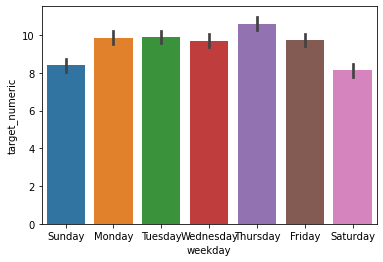

In [161]:
sns.barplot(x= df.weekday, y=df.target_numeric)

<AxesSubplot:xlabel='month', ylabel='target_numeric'>

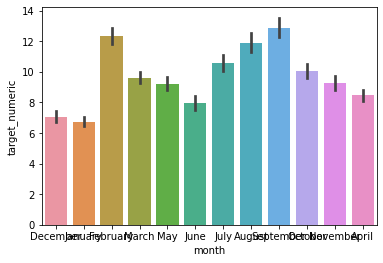

In [164]:
sns.barplot(x= df.month, y=df.target_numeric)